# Librairies

In [1]:
import pandas as pd 
import geopandas as gpd
import matplotlib.pylab as plt
import numpy as np
import os

In [69]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

# Load metadata

In [2]:
df = pd.read_csv('cities_summary.csv', delimiter = ',')
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs = 'epsg:4326')

# Compute global statistics

## Number of sensors

In [5]:
print(f'Data was found for {df.data_presence.sum()} cities')

Data was found for 53 cities


In [7]:
print(f'Harmonization was not achievable for {df[(df.data_presence) & (~df.treated_data)].shape[0]} cities')

Harmonization was not achievable for 17 cities


In [8]:
print(f'We harmonized data for {df.treated_data.sum()} cities')

We harmonized data for 36 cities


In [10]:
number_of_sensors = []
size = []
for country, city in df[df.treated_data][['country', 'city_name']].values:
    #print(country, city)
    l_files = []
    for filename in os.listdir(f'../{country}/{city}/treated/'):
        l_files.append(gpd.read_file(f'../{country}/{city}/treated/{filename}').shape[0])
    size.append(np.sum(l_files))
    number_of_sensors.append(np.mean(l_files))
print('Total number of rows', np.sum(size))
print('The number of sensors is', int(np.sum(number_of_sensors)), 'assuming most sensors are static and are the same from year to year')
print('Sum of average number of sensors')

Total number of rows 119689
The number of sensors is 34401 assuming most sensors are static and are the same from year to year
Sum of average number of sensors


In [11]:
df.loc[df.treated_data, 'new_nb_sensors'] = number_of_sensors
df.loc[df.new_nb_sensors.notna(), 'new_nb_sensors'] = df.loc[df.new_nb_sensors.notna(), 'new_nb_sensors'].apply(lambda x: round(x))
df.sort_values(by = ['country', 'city_name'])[['city_name', 'nb_sensors', 'new_nb_sensors']].dropna()

,city_name,nb_sensors,new_nb_sensors
0,Vienna,87.0,68.0
6,Brno,590.0,589.0
7,Copenhagen,592.0,43.0
9,Helsinki,54.0,56.0
16,Bordeaux,576.0,433.0
11,Grenoble,154.0,113.0
14,Lille,3744.0,760.0
13,Lyon,1713.0,343.0
18,Marseille,21232.0,10826.0
20,Montpellier,5079.0,1011.0


## Madatory variables

In [12]:
# Define conditions
conditions = [
    (df['AADT'] == True) & (df['AAWT'] == False),
    (df['AADT'] == False) & (df['AAWT'] == True),
    (df['AADT'] == True) & (df['AAWT'] == True),
    df[['AADT', 'AAWT']].isna().all(axis=1)  # Both are NaN
]

# Define corresponding values
choices = ['AADT', 'AAWT', 'Both', np.nan]

# Create new column
df['value_type'] = np.select(conditions, choices, default=np.nan)

df.sort_values(by = ['country', 'city_name'])[df.treated_data][['city_name', 'AADT', 'AAWT', 'value_type']]

c:\Users\xbonnema\miniconda3\envs\geodata\Lib\site-packages\geopandas\geodataframe.py:1750: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


,city_name,AADT,AAWT,value_type
0,Vienna,True,True,Both
6,Brno,True,False,AADT
7,Copenhagen,True,False,AADT
9,Helsinki,True,False,AADT
16,Bordeaux,False,True,AAWT
11,Grenoble,True,False,AADT
14,Lille,False,True,AAWT
13,Lyon,False,True,AAWT
18,Marseille,True,False,AADT
20,Montpellier,True,True,Both


## Temporal coverage

In [13]:

# Function to process years column
def process_years(years, source_start_year):
    if pd.isna(years) or pd.isna(source_start_year):  # If one is NaN, return NaN
        return np.nan
    
    first_year = int(years[:4])  # Extract the first 4 characters (first year in range)
    
    if source_start_year < first_year:  # Check if source_start_year is earlier
        return f"{years}*"
    
    return years

# Apply function to create new column
df['new_column'] = df.apply(lambda row: process_years(row['years'], row['source_start_year']), axis=1)


In [15]:
df[df.treated_data].sort_values(by = ['country', 'city_name'])[['city_name', 'years', 'source_start_year', 'new_column']]

,city_name,years,source_start_year,new_column
0,Vienna,2016-2024,2016.0,2016-2024
6,Brno,2016-2023,2016.0,2016-2023
7,Copenhagen,2015-2024,2009.0,2015-2024*
9,Helsinki,2015-2023,2010.0,2015-2023*
16,Bordeaux,2019-2023,2010.0,2019-2023*
11,Grenoble,2022,2022.0,2022
14,Lille,2015-2024,2012.0,2015-2024*
13,Lyon,2019-2023,2019.0,2019-2023
18,Marseille,2020,2020.0,2020
20,Montpellier,2015-2024,2011.0,2015-2024*


# OSM missing values

In [21]:
# Keep values

cities = []
osm_type = []
osm_lanes = []
osm_oneway = []
osm_name = []

for country, city in df[df.treated_data][['country', 'city_name']].values[::-1]: # Going reverse for boxplot later
    #df[df.treated_data][['country', 'city_name']]
    #print(country, city)
    l_files = []
    if city in ['Rouen', 'Copenhagen']:
        # We take the previous year to get more sensors
    # Read only the latest file
        filename = os.listdir(f'../{country}/{city}/treated/')[-2]
    else :
        filename = os.listdir(f'../{country}/{city}/treated/')[-1]
    gdf = gpd.read_file(f'../{country}/{city}/treated/{filename}')
    cities.append(city)
    
    # Should not happen
    if 'osm_type' not in gdf.columns:
        # Then we miss information
        print(country, city)
    
    
    osm_type.append(100* gdf.osm_type.isna().sum() / gdf.shape[0])
    osm_lanes.append(100* gdf.osm_lanes.isna().sum() / gdf.shape[0])
    osm_oneway.append(100* gdf.osm_oneway.isna().sum() / gdf.shape[0])
    osm_name.append(100* gdf.osm_name.isna().sum() / gdf.shape[0])


In [23]:
df_na = pd.DataFrame(index = cities, 
             data = {
                 'osm_type':osm_type, 'osm_lanes':osm_lanes, 'osm_oneway':osm_oneway, 'osm_name': osm_name
             })

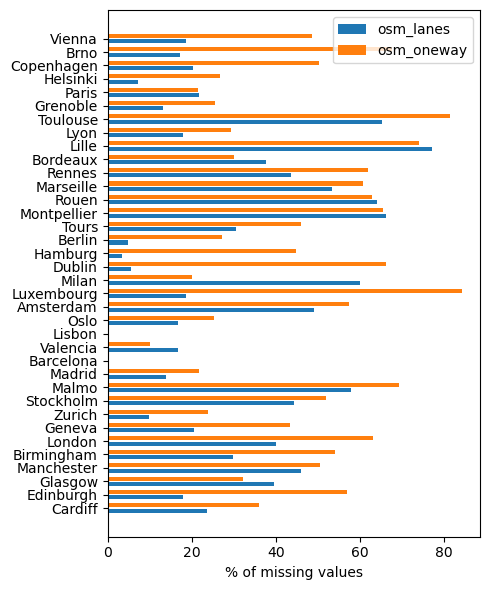

In [57]:
plt.figure(figsize = (5, 6))
plt.barh([x - .2 for x in range(36)], df_na.osm_lanes, label = 'osm_lanes', height = .3)
plt.barh([x + .2 for x in range(36)], df_na.osm_oneway, label = 'osm_oneway', height = .3)

plt.legend()
plt.yticks(range(36), df_na.index)
plt.xlabel('% of missing values')
plt.tight_layout()

# Per lane  Analysis 

In [61]:
aadts = []
aawts = []
cities = []
for country, city in df[df.treated_data][['country', 'city_name']].values[::-1]: # Going reverse for boxplot later
    #df[df.treated_data][['country', 'city_name']]
    #print(country, city)
    l_files = []
    if city in ['Rouen', 'Copenhagen']:
        # We take the previous year to get more sensors
    # Read only the latest file
        filename = os.listdir(f'../{country}/{city}/treated/')[-2]
    else :
        filename = os.listdir(f'../{country}/{city}/treated/')[-1]
    gdf = gpd.read_file(f'../{country}/{city}/treated/{filename}')
    cities.append(city)
    
    # Shoudl not happen
    if 'osm_type' not in gdf.columns:
        # Then we miss information
        print(country, city)
    
    if df.loc[(df.country == country) & (df.city_name == city)].AADT.values[0] :  
        gdf['AADT'] =   gdf['AADT'] / gdf['osm_lanes']   
        aadts.append([float(x) for x in gdf['AADT'].dropna().values])
        
    else:
        aadts.append([])
        
    if df.loc[(df.country == country) & (df.city_name == city)].AAWT.values[0] :
        gdf['AAWT'] =   gdf['AAWT'] / gdf['osm_lanes'] 
        aawts.append([float(x) for x in gdf['AAWT'].dropna().values])
        
    else:
        aawts.append([])
        


In [62]:
medians = []
for aadt, aawt in zip(aadts, aawts):
    #print([np.median(aadt), np.median(aawt)])
    medians.append(np.nanmean([np.median(aadt), np.median(aawt)]))
    #print(medians[-1])

c:\Users\xbonnema\miniconda3\envs\geodata\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\xbonnema\miniconda3\envs\geodata\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [63]:
sub = df[df.treated_data][['country', 'city_name']].reset_index()

In [64]:
sub['median'] = medians[::-1] # Because previous reverse
sub.sort_values('median', inplace=True)

In [66]:
# Retrieve data in correct order

aadts = []
aawts = []
cities = []
na_size = []
# In sorted dataframe"
for country, city in sub[['country', 'city_name']].values[::-1]: # Going reverse for boxplot later
    #print(country, city)
    l_files = []
    if city in ['Rouen', 'Copenhagen']:
        # We take the previous year to get more sensors
    # Read only the latest file
        filename = os.listdir(f'../{country}/{city}/treated/')[-2]
    else :
        filename = os.listdir(f'../{country}/{city}/treated/')[-1]
    gdf = gpd.read_file(f'../{country}/{city}/treated/{filename}')
    cities.append(city)
    na_size.append(100* gdf.osm_lanes.isna().sum() / gdf.shape[0])
    
    # Shoudl not happen
    if 'osm_type' not in gdf.columns:
        # Then we miss information
        print(country, city)
    
    if df.loc[(df.country == country) & (df.city_name == city)].AADT.values[0] :
        gdf['AADT'] =   gdf['AADT'] / gdf['osm_lanes'] 
        aadts.append([float(x) for x in gdf['AADT'].dropna().values])
        
    else:
        aadts.append([])
        
    if df.loc[(df.country == country) & (df.city_name == city)].AAWT.values[0] :
        gdf['AAWT'] =   gdf['AAWT'] / gdf['osm_lanes'] 
        aawts.append([float(x) for x in gdf['AAWT'].dropna().values])
        
    else:
        aawts.append([])
        

In [67]:
pd.Series(
    na_size,
    cities
)

Valencia       16.666667
Cardiff        23.611111
Manchester     46.111111
Birmingham     29.906542
Glasgow        39.698492
Helsinki        7.142857
London         40.068661
Hamburg         3.365385
Dublin          5.547226
Vienna         18.571429
Edinburgh      18.000000
Oslo           16.666667
Barcelona       0.000000
Montpellier    66.282723
Tours          30.530973
Malmo          57.894737
Marseille      53.436172
Brno           17.317487
Berlin          4.784689
Lyon           17.903930
Lisbon          0.000000
Amsterdam      49.209887
Luxembourg     18.750000
Bordeaux       37.681159
Copenhagen     20.359281
Stockholm      44.444444
Paris          21.718503
Geneva         20.560748
Rennes         43.561644
Zurich          9.756098
Rouen          64.166667
Grenoble       13.274336
Madrid         13.835156
Lille          77.067669
Toulouse       65.339233
Milan          60.000000
dtype: float64

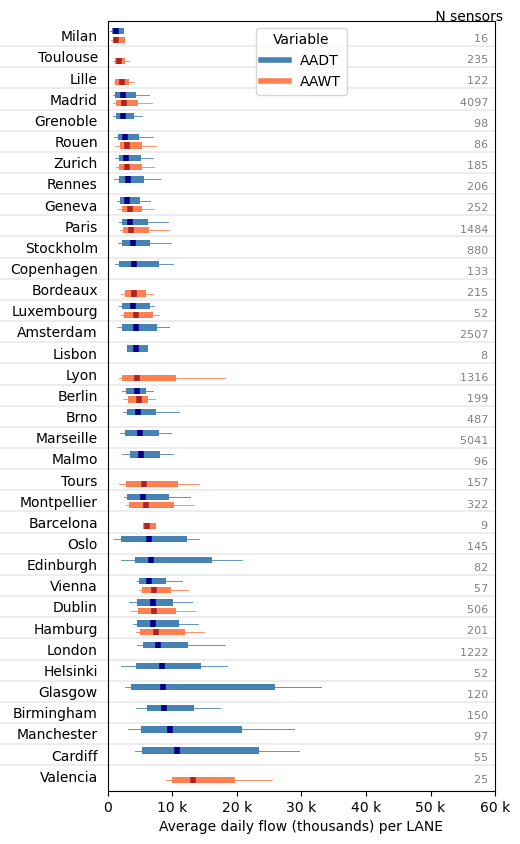

In [70]:
plt.figure(figsize = (5, 10))

# Colors
aadt_color = 'steelblue'
aawt_color = 'coral'
# Width of lines
aadt_lines = dict(linewidth=.6, color=aadt_color)
aawt_lines = dict(linewidth=.6, color=aawt_color)

for i, k in enumerate(cities):
    # Fo each city
    if len(aadts[i]) + len(aawts[i]) > 0 : # if we have data
        # AADT
        bp0 = plt.boxplot(aadts[i], orientation='horizontal', positions = [i + .2],
                    whis = (15, 85), 
                    showfliers=False, 
                    showcaps = False,
                    #meanline=True, showmeans=True, meanprops=dict(linestyle='solid', linewidth=2.5, color='firebrick'),
                    medianprops=dict(color = 'darkblue', lw = 4),
                    #boxprops=aadt_lines,
                    whiskerprops=aadt_lines,
                    widths = [.3],
                    #capprops=aadt_lines,
                    patch_artist=True
                    )
        # AAWT
        bp1 = plt.boxplot(aawts[i], orientation='horizontal', positions = [i - .2],
            whis = (15, 85), 
            showfliers=False, 
            showcaps = False,
            medianprops = dict(color = 'firebrick', lw = 4),
            # meanline=True, showmeans=True, meanprops=dict(linestyle='solid', linewidth=2.5, color='firebrick'),
            #boxprops=aawt_lines,
            whiskerprops=aawt_lines,
            widths = [.3],
            #capprops=aawt_lines,
            patch_artist=True
            )
        
        for box in bp0['boxes']:
            # change fill color
            box.set_facecolor(aadt_color)
            box.set_edgecolor(aadt_color)
            box.set_linewidth(0)
            
        for box in bp1['boxes']:
            # change fill color
            box.set_facecolor(aawt_color)
            box.set_edgecolor(aawt_color)
            box.set_linewidth(0)

# Legend custom
custom_legend = [
    Line2D([0], [0], lw = 4, color = aadt_color,  label='AADT'),
    Line2D([0], [0], lw = 4, color=aawt_color, label='AAWT'),
]
plt.legend(handles=custom_legend, title="Variable", loc='upper center', fontsize = 10, title_fontsize = 10)


# Add grey lines for readability
for k in range(len(cities)-1):
    plt.hlines(k + .5, -20000 , 60000,
               clip_on=False,
               lw = .1,
               color = 'k')
    
plt.annotate(' N sensors',
             (50000, len(cities)-.3)
)
    
# #Add number of sensors
# for i, z in enumerate(zip([len(k) for k in aadts], [len(k) for k in aawts])):
#     x, y = z
    
#     if x>0 and y >0 :
#         text = plt.annotate('  (', (60000, i-.3),)
#         text = plt.annotate(str(x), color = aadt_color, verticalalignment="bottom", xycoords=text, xy=(1, 0))
#         text = plt.annotate(',', verticalalignment="bottom", xycoords=text, xy=(1, 0))
#         text = plt.annotate(str(y), color = aawt_color, verticalalignment="bottom", xycoords=text, xy=(1, 0))
#         plt.annotate(')', verticalalignment="bottom", xycoords=text, xy=(1, 0))
#     elif x>0:
#         # text = plt.annotate('  n=', (70000, i-.3),)
#         text = plt.annotate(f'  {x}', (60000, i-.3),
#                             color = aadt_color, verticalalignment="bottom", 
#                             #xycoords=text, xy=(1, 0)
#                             )
        
#     elif y>0:
#         # text = plt.annotate('  n=', (70000, i-.3),)
#         text = plt.annotate(f'  {y}', (60000, i-.3),
#                             color = aawt_color, verticalalignment="bottom", 
#                             #xycoords=text, xy=(1, 0)
#                             )
# Black
for i, z in enumerate(zip([len(k) for k in aadts], [len(k) for k in aawts])):
    x, y = z
    if x>0 and y >0 :
        plt.annotate(f'{int(np.mean([x, y]))}  ', (60000, i-.3), color ='k', fontsize = 8, alpha = .5, horizontalalignment = 'right')
    elif x>0:
        plt.annotate(f'{x}  ', (60000, i-.3), color ='k', fontsize = 8, alpha = .5, horizontalalignment = 'right')
    elif y>0:
        plt.annotate(f'{y}  ', (60000, i-.3), color ='k', fontsize = 8, alpha = .5, horizontalalignment = 'right')
        
# Format axis
plt.xlim(0, 60000)
plt.gca().xaxis.set_major_formatter(ticker.EngFormatter(unit=''))
plt.xlabel('Average daily flow (thousands) per LANE')

plt.yticks(range(len(aadts)), cities)
plt.tick_params(left = False) 

plt.show()

# Available features

In [102]:
# Keep values

cities = []
columns = []

for country, city in df[df.treated_data][['country', 'city_name']].values[::-1]: # Going reverse for boxplot later
    #df[df.treated_data][['country', 'city_name']]
    #print(country, city)
    l_files = []
    if city in ['Rouen', 'Copenhagen']:
        # We take the previous year to get more sensors
    # Read only the latest file
        filename = os.listdir(f'../{country}/{city}/treated/')[-2]
    else :
        filename = os.listdir(f'../{country}/{city}/treated/')[-1]
    gdf = gpd.read_file(f'../{country}/{city}/treated/{filename}')
    cities.append(city)
    
    # Should not happen
    if 'osm_type' not in gdf.columns:
        # Then we miss information
        print(country, city)
    
    
    columns.append(gdf.columns)



In [107]:
values = [
    'AADT', 'AAWT',
    'TR_AADT', 'TR_pct_AADT', 'TR_AAWT', 'TR_pct_AAWT', '2W_AADT',
    'savg', 's85',
    'TR_savg', 'TR_savg',
    'raw_name',
    'raw_oneway',
    'raw_direction',
    'raw_lanes',
    'raw_techno'
]

In [108]:
values_dict = dict((key, []) for key in values)

In [109]:
for city, col in zip(cities, columns):
    # We search for every key
    for key in values_dict.keys() :
        # Check if the variable is in the dataset
        if key in col :
            values_dict[key].append("✓")
        else :
            values_dict[key].append(np.NaN)

In [111]:
clip = pd.DataFrame(index = cities,
             data = values_dict)[::-1]

In [116]:
clip.to_clipboard()